In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz, trapz
plt.rcParams['figure.figsize'] = 15, 8
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
markerlist = ["d", "x", "o"]
#constants:
delta_a=1.92e-10
rho_l=1000
Rv=462
T=293.15
T_C = T -273.15
pv_sat = 611 * np.exp((17.08 * T_C)/(234.18 + T_C))





# Vapour Diffusion

In [27]:
def vap_fit(w,ld0,a,b):
    return a + (ld0 - a) * np.exp(-b * w) + 0 * w

In [28]:
vapour_diff = pd.read_excel("HS20_MBS_BPTA_201202_Exercise_Data.xls", sheet_name="vapour diff", header=13, nrows=3)

In [29]:
vapour_diff["Kv"] = (delta_a * vapour_diff["RH"] * pv_sat)/(vapour_diff["mu"] * rho_l * Rv * T)
vapour_diff["Dv"] = vapour_diff["Kv"] / vapour_diff["cap"]
vapour_diff["LDv"] = np.log10(vapour_diff["Dv"],)
vapour_diff

,RH,mu,Kv,pc,log pc,w1,w2,w,dwdpc1,dwdpc2,cap,Dv,LDv,fit LDv,Unnamed: 14,plot w,fit LDv.1
0,0.30,23,4.331768e-17,1.630604e+08,8.212349,2.156635,4.711406,6.868041,-1.123541e-08,-1.733502e-08,2.857043e-08,1.516172e-09,-8.819252,NaN,NaN,0,NaN
1,0.70,12,1.937263e-16,4.830638e+07,7.684004,6.051529,9.774440,15.825969,-1.058855e-07,-1.213490e-07,2.272345e-07,8.525390e-10,-9.069286,NaN,NaN,2,NaN
2,0.92,3,1.018447e-15,1.129281e+07,7.052802,20.118663,23.340691,43.459354,-1.398258e-06,-1.234226e-06,2.632484e-06,3.868767e-10,-9.412427,NaN,NaN,4,NaN


/Users/pick/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Parameters:
ld0: -8.540377098144795
a: -9.537522544757138
b: 0.047764688424495466


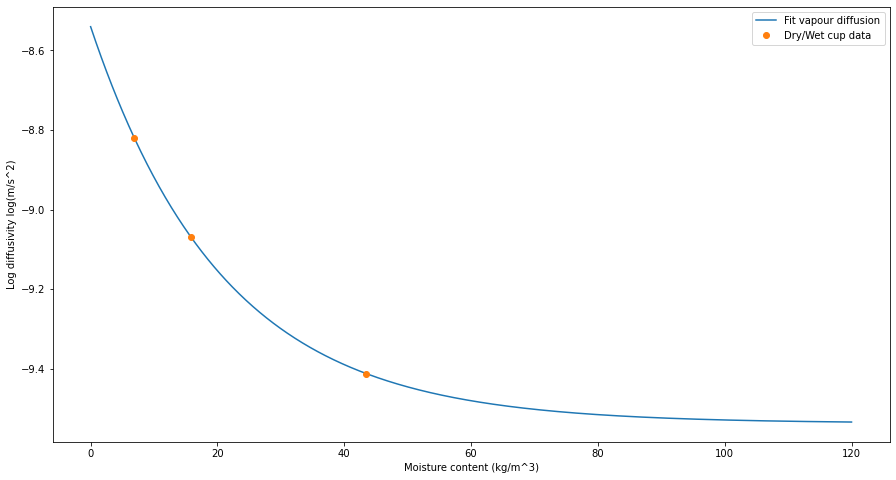

In [30]:
popt, pcov = curve_fit(vap_fit, vapour_diff["w"], vapour_diff["LDv"])
x = np.linspace(0,120,1000)
plt.plot(x, vap_fit(x, *popt), label="Fit vapour diffusion")
plt.plot(vapour_diff["w"], vapour_diff["LDv"], "o", label="Dry/Wet cup data")
plt.ylabel("Log diffusivity log(m/s^2)")
plt.xlabel("Moisture content (kg/m^3)")
plt.legend()
print("Parameters:\nld0: {}\na: {}\nb: {}".format(*popt))

# Liquid diffusivity

In [66]:
liquid_diff = pd.read_excel("HS20_MBS_BPTA_201202_Exercise_Data.xls", sheet_name="liquid diff", header=7)


In [84]:
liquid_diff["lambda"][1:] + liquid_diff["lambda"][0:]

0          NaN
1     0.000258
2     0.000256
3     0.000253
4     0.000253
        ...   
84    0.000017
85    0.000013
86    0.000008
87    0.000004
88    0.000000
Name: lambda, Length: 89, dtype: float64

In [112]:
liquid_diff["dw/dlambda"][1:] = np.diff(liquid_diff["w"])/np.diff(liquid_diff["lambda"])
liquid_diff["int"][1:] = cumtrapz(liquid_diff["lambda"], liquid_diff["w"], axis=0)

In [113]:
liquid_diff

,lambda,w,dw/dlambda,dint,int,Dl,LDl,fit LDI,Unnamed: 8
0,0.000130,0.000000,NaN,NaN,0.024074,NaN,NaN,NaN,NaN
1,0.000129,15.630013,-1.510321e+07,8.087594e-06,0.002024,NaN,NaN,NaN,NaN
2,0.000128,18.757759,-2.680067e+06,1.825102e-06,0.002425,NaN,NaN,NaN,NaN
3,0.000127,21.833037,-2.653420e+06,1.782103e-06,0.002817,NaN,NaN,NaN,NaN
4,0.000126,33.146019,-4.371773e+07,1.463749e-06,0.004248,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
84,0.000008,237.515052,-1.775234e+05,3.881653e-07,0.024068,NaN,NaN,NaN,NaN
85,0.000006,237.886289,-1.775235e+05,3.881655e-07,0.024071,NaN,NaN,NaN,NaN
86,0.000004,238.257526,-1.775207e+05,3.881712e-07,0.024073,NaN,NaN,NaN,NaN
87,0.000002,238.628763,-1.775225e+05,3.881673e-07,0.024074,NaN,NaN,NaN,NaN
